In [ ]:
import os
from dotenv import load_dotenv

from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd


# connexion à Neon
load_dotenv()

url = URL.create(
    drivername="postgresql+psycopg2",
    username=os.getenv("NEON_USER"),
    password=os.getenv("NEON_PASSWORD"),
    host=os.getenv("NEON_HOST"),
    port=int(os.getenv("NEON_PORT", "5432")),
    database=os.getenv("NEON_DB"),
    query={"sslmode": os.getenv("NEON_SSLMODE", "require")},
)

engine = create_engine(url, pool_pre_ping=True)

# test connexion
test_df = pd.read_sql("SELECT now() AS now, version() AS version;", engine)
print(test_df)


# chargement des tables
fact_env = pd.read_sql(
    """
    SELECT country_key,
           year,
           coal_consumption,
           gas_consumption,
           oil_consumption
    FROM fact_energy_environment;
    """,
    engine,
)

fact_soc = pd.read_sql(
    """
    SELECT country_key,
           year,
           gdp
    FROM fact_socio_economy;
    """,
    engine,
)

dim_country = pd.read_sql(
    """
    SELECT country_key,
           country_name,
           iso_code
    FROM dim_country;
    """,
    engine,
)

# top 10 pays par GDP en 2020
soc_2020 = fact_soc[
    (fact_soc["year"] == 2020) & fact_soc["gdp"].notna()
]

top10_2020 = (
    soc_2020
    .nlargest(10, "gdp")
    .merge(
        dim_country[["country_key", "country_name", "iso_code"]],
        on="country_key",
        how="left",
    )
)

print("\nTop 10 GDP 2020 :")
print(top10_2020[["country_name", "iso_code", "gdp"]])


def build_country_scenarios_rf(
    country_key: int,
    start_year: int = 2020,
    end_year: int = 2025,
    rates=(0.02, 0.03, 0.04),
):
    """
    Scénarios de GDP pour un pays donné en utilisant :
      - total_energy_fossil = coal + gas + oil
      - gas_ratio = gas / total
      - oil_ratio = oil / total
    et un modèle RandomForestRegressor.

    Retourne :
      - hist : DataFrame ["year", "gdp"]
      - scenarios : dict {label_scenario: DataFrame ["year", "gdp_pred"]}
    """

    # fusionner socio + énergie pour le pays
    df = (
        fact_soc[fact_soc["country_key"] == country_key]
        .merge(
            fact_env[
                [
                    "country_key",
                    "year",
                    "coal_consumption",
                    "gas_consumption",
                    "oil_consumption",
                ]
            ],
            on=["country_key", "year"],
            how="inner",
        )
    )

    # nettoyer et créer les nouvelles features
    df_clean = df[
        [
            "year",
            "gdp",
            "coal_consumption",
            "gas_consumption",
            "oil_consumption",
        ]
    ].dropna()

    if df_clean.empty:
        raise ValueError(f"Pas assez de données complètes pour country_key={country_key}")

    df_clean = df_clean.sort_values("year")

    # total énergie fossile
    df_clean["total_energy_fossil"] = (
        df_clean["coal_consumption"]
        + df_clean["gas_consumption"]
        + df_clean["oil_consumption"]
    )

    # éviter les divisions par zéro
    df_clean = df_clean[df_clean["total_energy_fossil"] > 0]

    # ratios
    df_clean["gas_ratio"] = df_clean["gas_consumption"] / df_clean["total_energy_fossil"]
    df_clean["oil_ratio"] = df_clean["oil_consumption"] / df_clean["total_energy_fossil"]

    # features / target pour le random forest
    feature_cols = ["total_energy_fossil", "gas_ratio", "oil_ratio"]
    X = df_clean[feature_cols].values
    y = df_clean["gdp"].values

    #random forest
    rf = RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        min_samples_leaf=3,
        n_jobs=-1,
    )
    rf.fit(X, y)

    def predict_gdp_from_features(total_energy_fossil, gas_ratio, oil_ratio):
        return float(
            rf.predict([[total_energy_fossil, gas_ratio, oil_ratio]])[0]
        )

    # récupérer la ligne de référence pour start_year (ex : 2020)
    row_start = df_clean[df_clean["year"] == start_year]
    if row_start.empty:
        raise ValueError(
            f"Pas de données énergie + gdp pour {start_year} (country_key={country_key})"
        )
    row_start = row_start.iloc[0]

    coal_0 = row_start["coal_consumption"]
    gas_0 = row_start["gas_consumption"]
    oil_0 = row_start["oil_consumption"]
    gdp_real_start = row_start["gdp"]

    total_0 = coal_0 + gas_0 + oil_0
    gas_ratio_0 = gas_0 / total_0
    oil_ratio_0 = oil_0 / total_0

    # offset pour recaler le modèle sur le GDP réel de l'année de départ
    gdp_pred_start = predict_gdp_from_features(total_0, gas_ratio_0, oil_ratio_0)
    offset = gdp_real_start - gdp_pred_start

    years = list(range(start_year, end_year + 1))
    scenarios = {}

    # construire les scénarios pour chaque taux de baisse
    for rate in rates:
        label = f"-{int(rate * 100)}% par an"
        coal = coal_0
        gas = gas_0
        oil = oil_0

        rows = []

        for i, year in enumerate(years):
            if i > 0:
                # baisse des consommations de 'rate' chaque année
                coal *= (1 - rate)
                gas *= (1 - rate)
                oil *= (1 - rate)

            total = coal + gas + oil
            # les ratios restent en pratique quasi constants si on applique
            # la même baisse à tout, mais on les recalcule proprement :
            gas_ratio = gas / total
            oil_ratio = oil / total

            gdp_pred = predict_gdp_from_features(total, gas_ratio, oil_ratio)
            gdp_pred_aligned = gdp_pred + offset

            rows.append({"year": year, "gdp_pred": gdp_pred_aligned})

        scenarios[label] = pd.DataFrame(rows)

    # historique pour le graph
    hist = df_clean[
        (df_clean["year"] >= 2010) & (df_clean["year"] <= start_year)
    ][["year", "gdp"]].copy()

    return hist, scenarios


                               now  \
0 2025-12-17 15:15:50.950026+00:00   

                                             version  
0  PostgreSQL 17.7 (bdc8956) on aarch64-unknown-l...  

Top 10 GDP 2020 :
     country_name iso_code           gdp
0           China      CHN  2.415184e+13
1   United States      USA  1.802736e+13
2           India      IND  8.945313e+12
3           Japan      JPN  4.626661e+12
4         Germany      DEU  3.742721e+12
5          Russia      RUS  3.606717e+12
6       Indonesia      IDN  3.204973e+12
7          Brazil      BRA  2.950377e+12
8          France      FRA  2.438594e+12
9  United Kingdom      GBR  2.334804e+12


In [10]:
import matplotlib.pyplot as plt

def plot_country_scenarios_rf(country_key):
    row_country = dim_country[dim_country["country_key"] == country_key].iloc[0]
    name = row_country["country_name"]
    iso = row_country["iso_code"]

    hist, scenarios = build_country_scenarios_rf(country_key)

    plt.figure(figsize=(9, 5))

    # GDP réel
    plt.plot(hist["year"], hist["gdp"], marker="o", label="GDP réel")

    # Scénarios
    for label, sdf in scenarios.items():
        plt.plot(
            sdf["year"],
            sdf["gdp_pred"],
            marker="o",
            linestyle="--",
            label=f"Scénario {label}",
        )

    plt.xlabel("Année")
    plt.ylabel("GDP")
    plt.title(f"Scénarios de GDP (Random Forest) pour {name} ({iso})")
    plt.legend()
    plt.tight_layout()
    plt.show()



=== China (CHN) ===


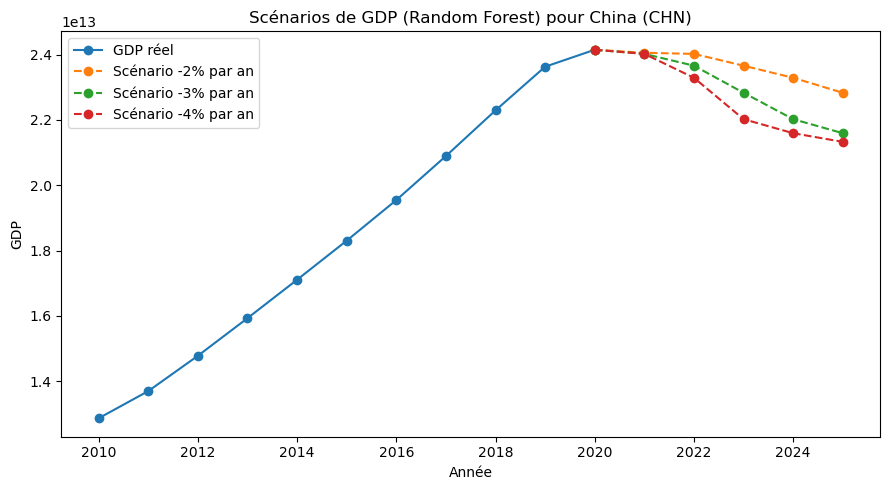


=== United States (USA) ===


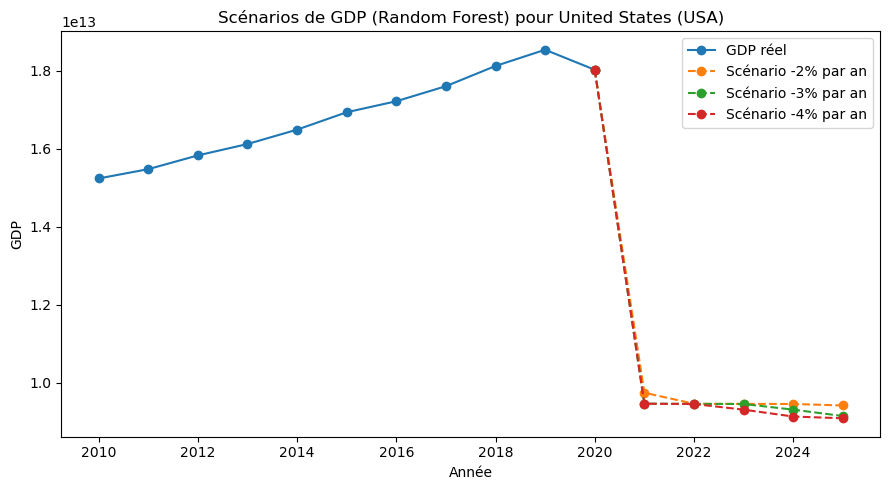


=== India (IND) ===


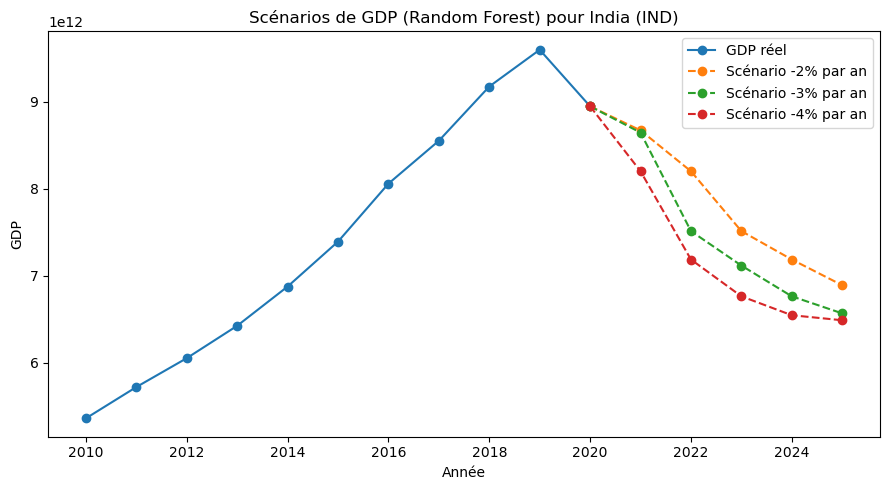


=== Japan (JPN) ===


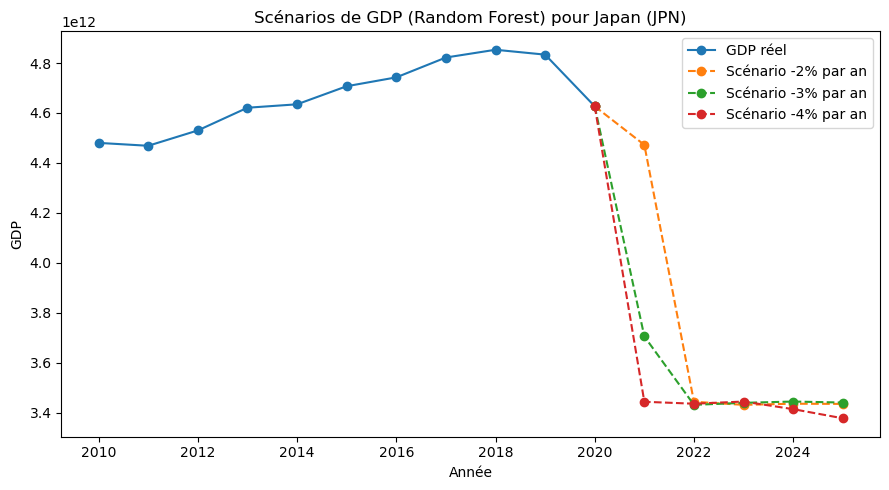


=== Germany (DEU) ===


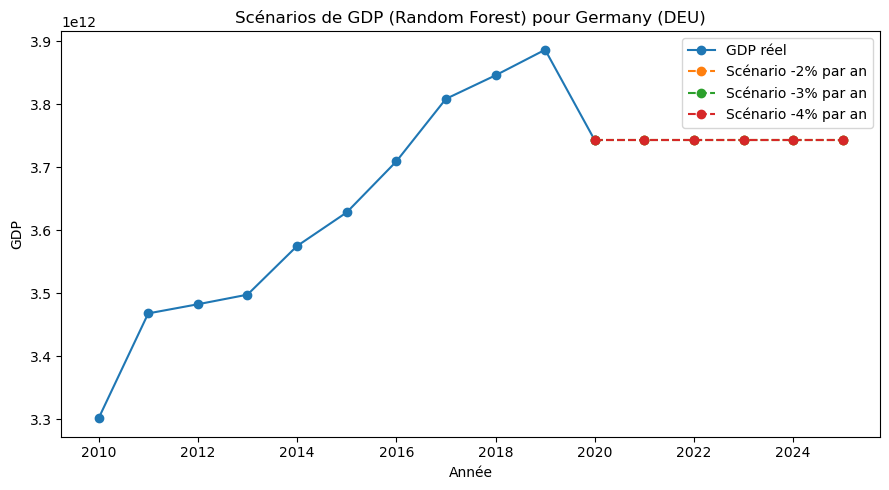


=== Russia (RUS) ===


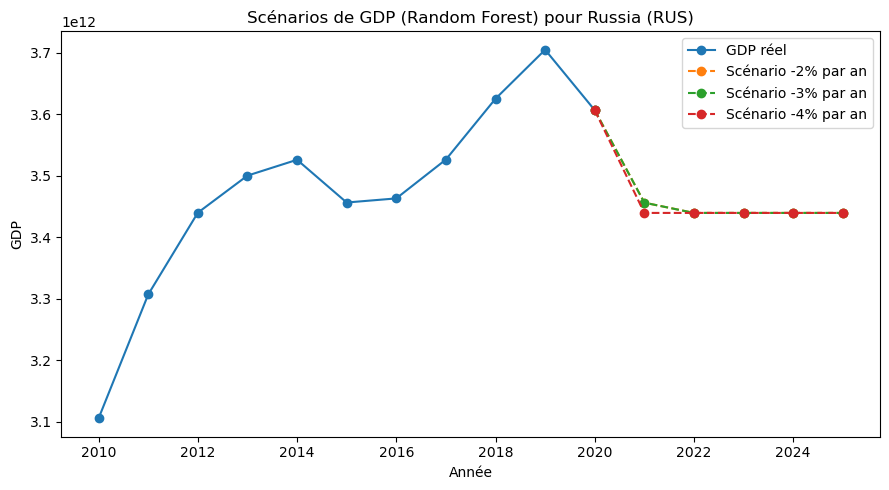


=== Indonesia (IDN) ===


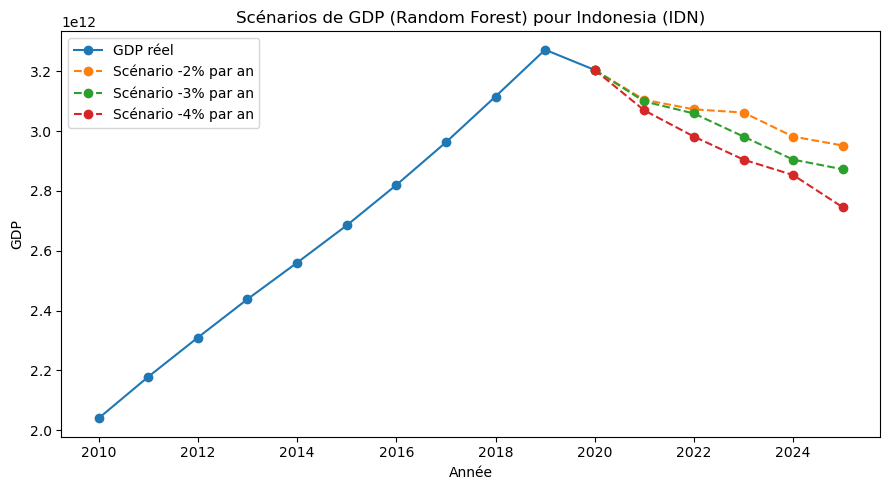


=== Brazil (BRA) ===


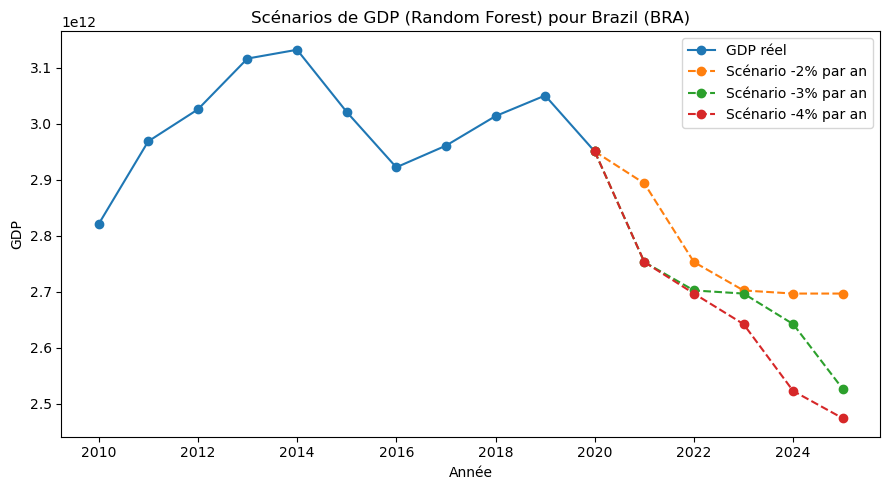


=== France (FRA) ===


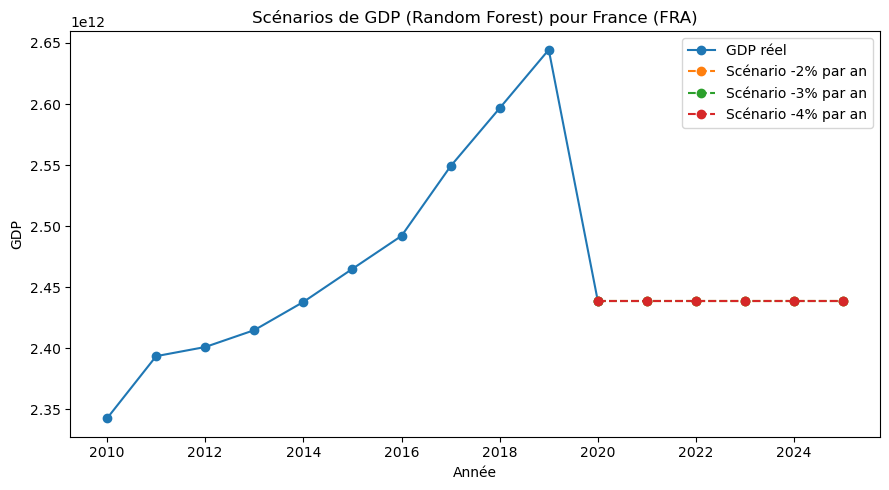


=== United Kingdom (GBR) ===


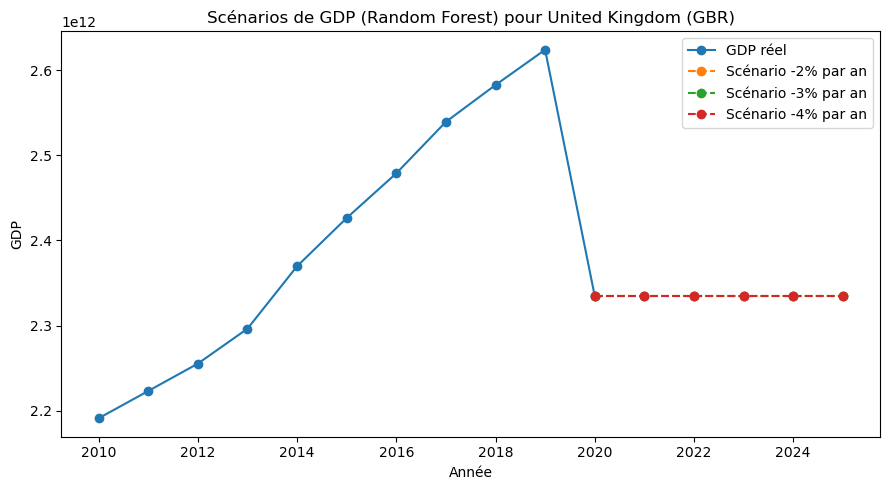

In [11]:
for _, row in top10_2020.iterrows():
    print(f"\n=== {row['country_name']} ({row['iso_code']}) ===")
    plot_country_scenarios_rf(row["country_key"])


TEST SANS LES RATIOS 

In [ ]:
def build_country_scenarios_rf(
    country_key: int,
    start_year: int = 2020,
    end_year: int = 2025,
    rates=(0.02, 0.03, 0.04),
):
    """
    Scénarios de GDP pour un pays donné en utilisant un RandomForestRegressor
    avec comme features :
      - coal_consumption
      - gas_consumption
      - oil_consumption

    Retourne :
      - hist : DataFrame ["year", "gdp"]
      - scenarios : dict {label_scenario: DataFrame ["year", "gdp_pred"]}
    """

    # fusionner socio + énergie pour le pays
    df = (
        fact_soc[fact_soc["country_key"] == country_key]
        .merge(
            fact_env[
                [
                    "country_key",
                    "year",
                    "coal_consumption",
                    "gas_consumption",
                    "oil_consumption",
                ]
            ],
            on=["country_key", "year"],
            how="inner",
        )
    )

    # garder uniquement les colonnes utiles et enlever les NaN
    df_clean = df[
        [
            "year",
            "gdp",
            "coal_consumption",
            "gas_consumption",
            "oil_consumption",
        ]
    ].dropna()

    if df_clean.empty:
        raise ValueError(f"Pas assez de données complètes pour country_key={country_key}")

    df_clean = df_clean.sort_values("year")

    # features / target pour le Random Forest
    feature_cols = ["coal_consumption", "gas_consumption", "oil_consumption"]
    X = df_clean[feature_cols].values
    y = df_clean["gdp"].values

    rf = RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        min_samples_leaf=3,
        n_jobs=-1,
    )
    rf.fit(X, y)

    def predict_gdp_from_features(coal, gas, oil):
        return float(rf.predict([[coal, gas, oil]])[0])

    # récupérer la ligne de référence pour start_year (ex : 2020)
    row_start = df_clean[df_clean["year"] == start_year]
    if row_start.empty:
        raise ValueError(
            f"Pas de données énergie + gdp pour {start_year} (country_key={country_key})"
        )
    row_start = row_start.iloc[0]

    coal_0 = row_start["coal_consumption"]
    gas_0 = row_start["gas_consumption"]
    oil_0 = row_start["oil_consumption"]
    gdp_real_start = row_start["gdp"]

    # offset pour recaler les scénarios sur le GDP réel de l'année de départ
    gdp_pred_start = predict_gdp_from_features(coal_0, gas_0, oil_0)
    offset = gdp_real_start - gdp_pred_start

    years = list(range(start_year, end_year + 1))
    scenarios = {}

    # construire les scénarios pour chaque taux de baisse
    for rate in rates:
        label = f"-{int(rate * 100)}% par an"
        coal = coal_0
        gas = gas_0
        oil = oil_0

        rows = []

        for i, year in enumerate(years):
            if i > 0:
                # baisse des consommations de 'rate' chaque année
                coal *= (1 - rate)
                gas *= (1 - rate)
                oil *= (1 - rate)

            gdp_pred = predict_gdp_from_features(coal, gas, oil)
            gdp_pred_aligned = gdp_pred + offset

            rows.append({"year": year, "gdp_pred": gdp_pred_aligned})

        scenarios[label] = pd.DataFrame(rows)

    # historique pour le graph (2010 → année de départ incluse)
    hist = df_clean[
        (df_clean["year"] >= 2010) & (df_clean["year"] <= start_year)
    ][["year", "gdp"]].copy()

    return hist, scenarios


In [13]:
import matplotlib.pyplot as plt

def plot_country_scenarios_rf(country_key):
    row_country = dim_country[dim_country["country_key"] == country_key].iloc[0]
    name = row_country["country_name"]
    iso = row_country["iso_code"]

    hist, scenarios = build_country_scenarios_rf(country_key)

    plt.figure(figsize=(9, 5))

    # GDP réel
    plt.plot(hist["year"], hist["gdp"], marker="o", label="GDP réel")

    # Scénarios
    for label, sdf in scenarios.items():
        plt.plot(
            sdf["year"],
            sdf["gdp_pred"],
            marker="o",
            linestyle="--",
            label=f"Scénario {label}",
        )

    plt.xlabel("Année")
    plt.ylabel("GDP")
    plt.title(f"Scénarios de GDP (Random Forest) pour {name} ({iso})")
    plt.legend()
    plt.tight_layout()
    plt.show()



=== China (CHN) ===


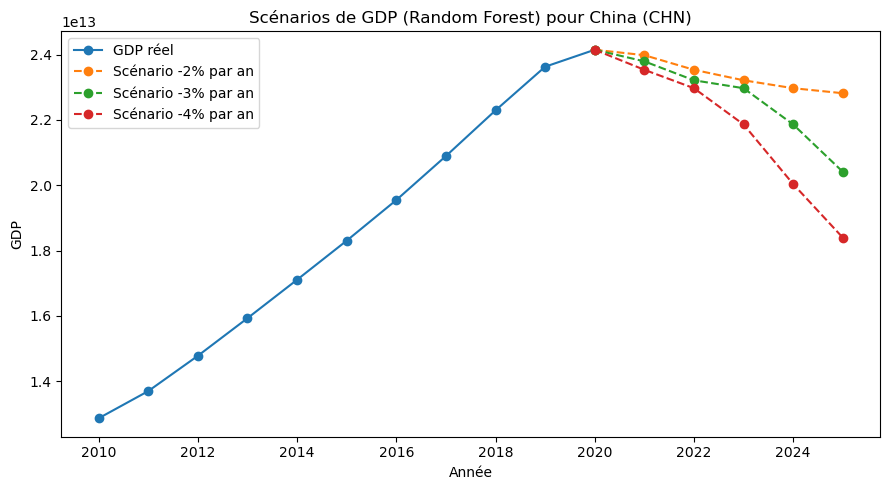


=== United States (USA) ===


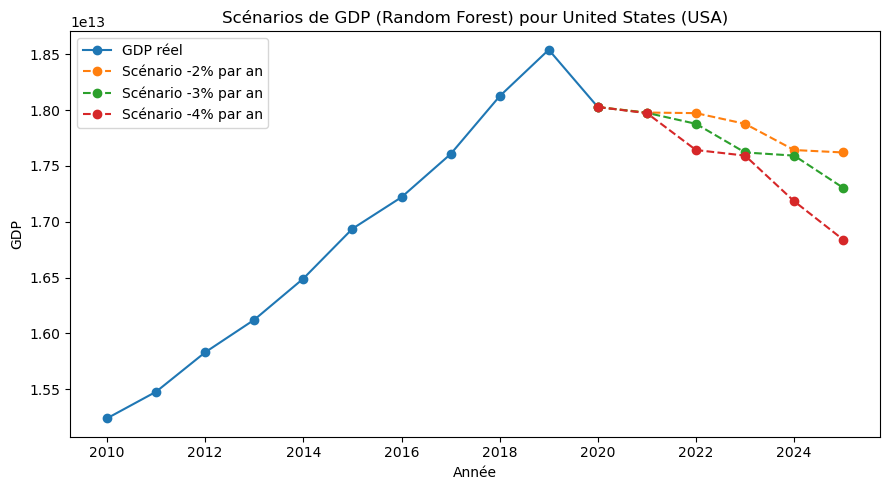


=== India (IND) ===


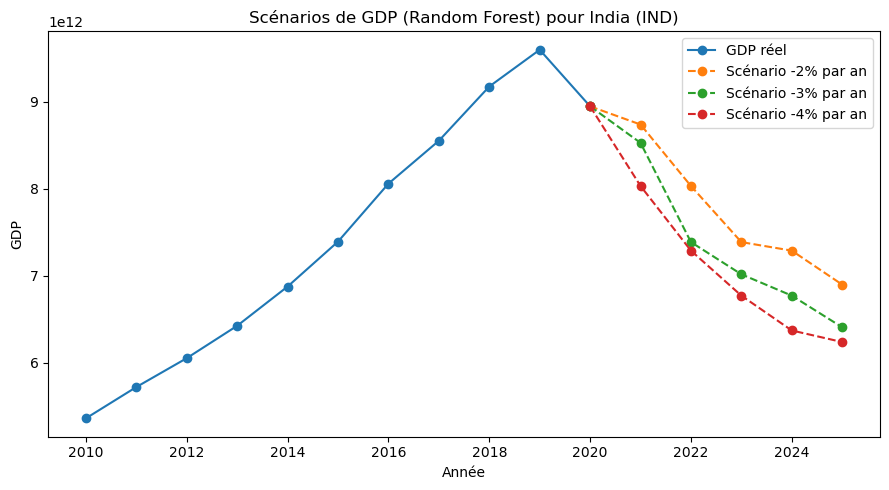


=== Japan (JPN) ===


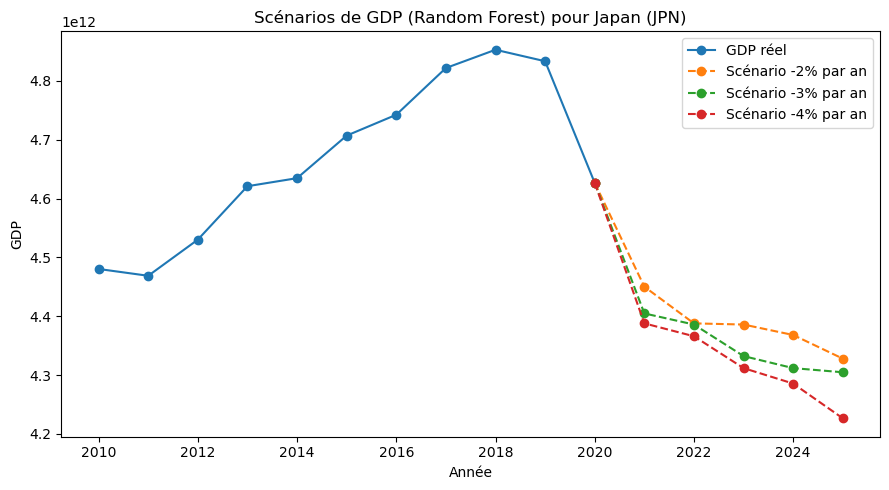


=== Germany (DEU) ===


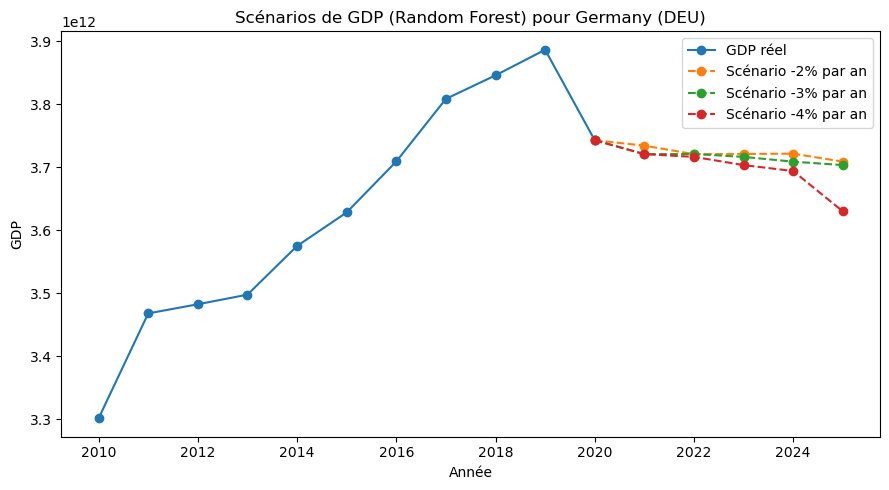


=== Russia (RUS) ===


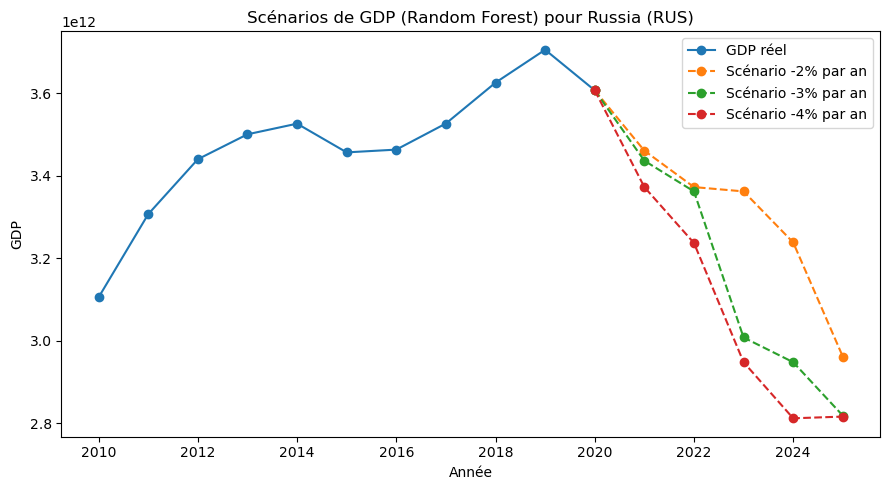


=== Indonesia (IDN) ===


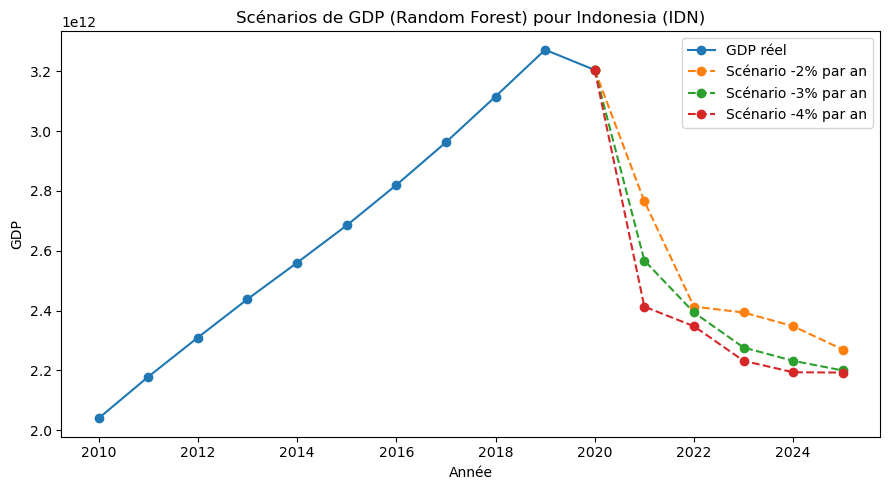


=== Brazil (BRA) ===


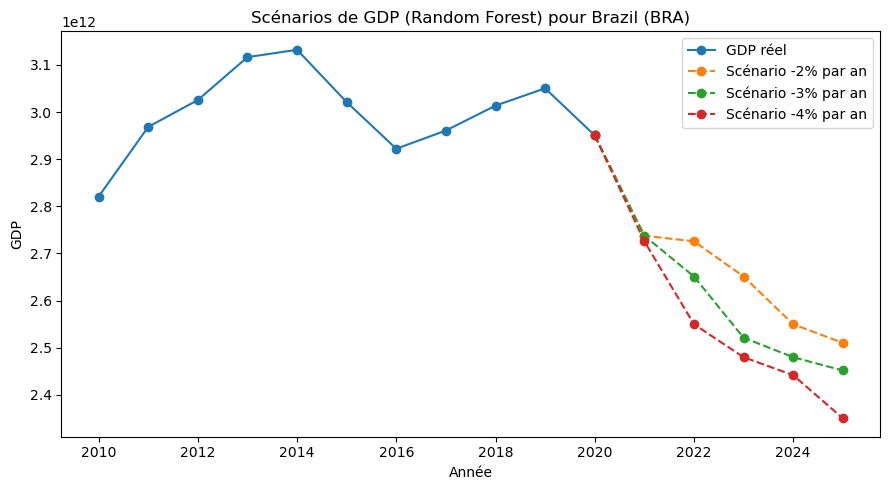


=== France (FRA) ===


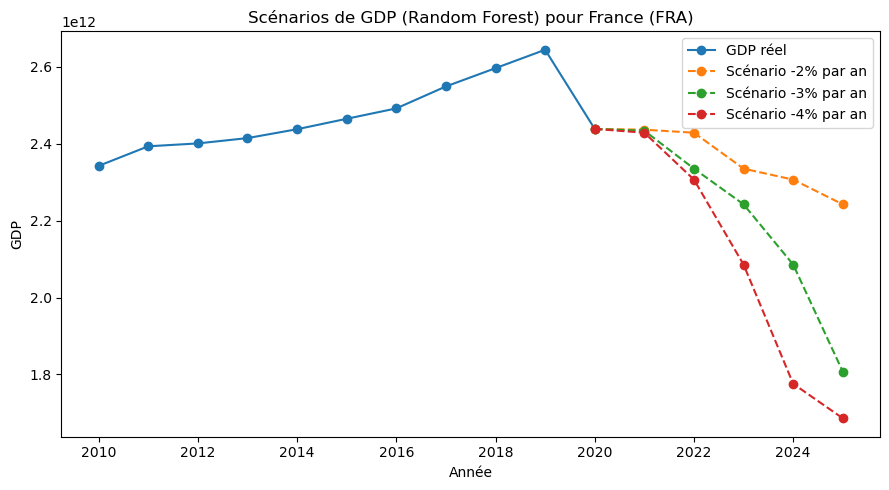


=== United Kingdom (GBR) ===


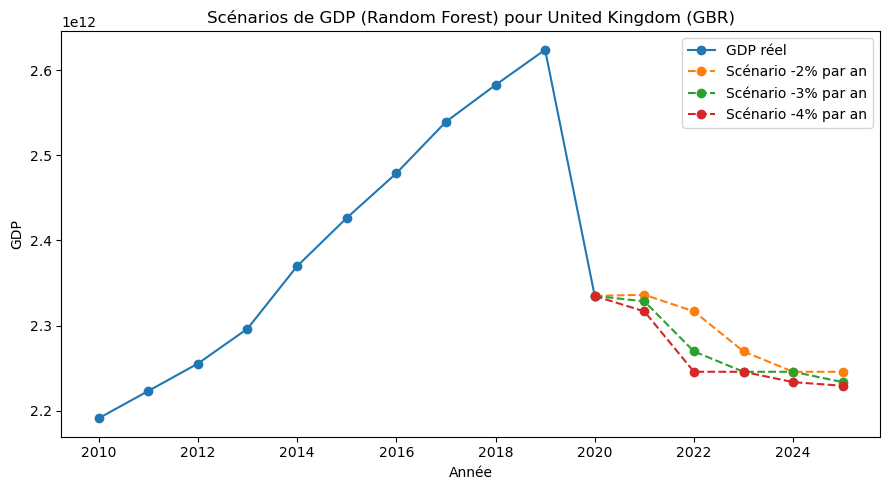

In [14]:
for _, row in top10_2020.iterrows():
    print(f"\n=== {row['country_name']} ({row['iso_code']}) ===")
    plot_country_scenarios_rf(row["country_key"])
